# PCM correlation models 
This demo is meant to show two common ways to use PCM correlation models: 1) to estimate the true correlation between two activity patterns; 2) to test hypotheses about the specific correlation between two sets of activity patterns. 

>For more information on this topic, see also our recent blog [*Brain, Data, and Science*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation).

## 1. Estimating the true correlation between two activity patterns or conditions
In the first part of this jupyter notebook, we'll focus on the question of how to estimate the true correlation between noisy activity patterns. 

>The following simulation produces the figures (Fig. 2, 3, and 4) shown in the blog post ["Estimating correlations between noisy activity patterns. A tricky problem with a generative solution."](http://www.diedrichsenlab.org/BrainDataScience/noisy_correlation/index.htm).

In [213]:
# First import necessary libraries
import numpy as np 
import PcmPy as pcm
from PcmPy import sim
import pandas as pd
from correlation_demo import do_sim, plot_Figure2, plot_Figure3, plot_Figure4

### 1.1 Simply correlating mean activity patterns
First, we'll look at the what's the problem with simply using the correlation between two measured activty patterns to estimate their true correlation. Here we write a little function to calculate the correlation between two mean activity patterns:

In [214]:
def get_corr(X,cond_vec):
    """
        Get normal correlation
    """
    p1 = X[cond_vec==0,:].mean(axis=0)
    p2 = X[cond_vec==1,:].mean(axis=0)
    return np.corrcoef(p1,p2)[0,1]

Now we use the pcm-toolbox to simulate data from an underlying true correlation model (M).

In [215]:
def do_sim(corr,signal=np.linspace(0,5,20), n_sim=50, randseed=None):
    M = pcm.CorrelationModel('corr', num_items=1, corr=corr, cond_effect=False)
    G,dG = M.predict([0,0])
    cond_vec, part_vec = pcm.sim.make_design(2,2)
    Lcorr = []
    Lsign = []
    rng = np.random.default_rng(randseed)

    for s in signal:
        D = pcm.sim.make_dataset(M, [0,0], cond_vec, n_sim=n_sim, signal=s, rng=rng)
        for i in range(n_sim):
            data = D[i].measurements
            Lcorr.append(get_corr(data, cond_vec))
            Lsign.append(s)

    S = pd.DataFrame({'r_naive':Lcorr, 'signal':Lsign})
    S['true'] = np.ones((S.shape[0],))*corr
    return S

Now we can run the simulation to create Figure 2 in the blog.

In [218]:
# Make a spacing of different signals
sig = np.linspace(0.1, 5.1, 21) 
#sig = np.logspace(np.log(0.2),np.log(5),10)

# Get the simulations
D = do_sim(0.7, n_sim=200, signal=sig, randseed=10)

# Summarize the mean and std deviation
T = D.groupby("signal").apply(np.mean)
Tstd = D.groupby("signal").apply(np.std)

# Plot and show the Figure
fig = plot_Figure2(D, T, Tstd)
fig.update_layout(width=700, height=400)

This is a function that runs a specific simulation across a range of signal to noise levels.

### 1.2 Solution 1: Using noise ceiling correction and cross-validated estimates
We can calculate the noise ceiling to correct for the bias in the correlation. Here a function that uses the cross-measurement correlations to obtain an estimate of the noise ceiling.

In [189]:
def get_noiseceil(X,cond_vec):
    """
        Calculate noise ceiling over reliabilities
    """
    rel = np.array([0.0,0.0])
    for i in [0,1]:
        N = np.sum(cond_vec==i) # Number of measurements
        R = np.corrcoef(X[cond_vec==i,:]) # Correlation matrix
        index_R = np.where(~np.eye(N,dtype=bool)) # Average cross-block correlations
        r = np.mean(R[index_R]) # Average the non-diagnal elements.
        rel[i] = r * N / (r*(N-1)+1) # Overall realibility of the mean

    # Check if both are above zero
    if rel[0]>0 and rel[1]>0:
        noise_r = np.sqrt(rel[0]*rel[1])
    else:
        noise_r = np.nan
    return noise_r

Alternatively we can use the cross-block information direction to caluculate correct coefficients. Here we use `est_G_crossval` to calculate those covariances.

In [190]:
def get_crossblock(X,cond_vec,part_vec):
    """
        calculate the cross-block correlation
    """
    G = pcm.util.est_G_crossval(X,cond_vec,part_vec)
    var = G[0][0,0]*G[0][1,1]
    if var<=0:
        crosscorr = np.nan
    else:
        crosscorr = G[0][0,1]/np.sqrt(var)
    return crosscorr

Now we need to extend our do_sim function to get these addtional measures

In [192]:
def do_sim(corr,signal=np.linspace(0,5,20),n_sim=50,randseed=None):
    M = pcm.CorrelationModel('corr',num_items=1,corr=corr,cond_effect=False)
    G,dG = M.predict([0,0])
    cond_vec,part_vec = pcm.sim.make_design(2,2)
    Lcorr = []
    LnoiseCeil = []
    Lsign = []
    LcrossBlock =[]
    rng = np.random.default_rng(randseed)

    for s in signal:
        D = pcm.sim.make_dataset(M, [0,0], cond_vec, n_sim=n_sim, signal=s,rng=rng)
        for i in range(n_sim):
            data = D[i].measurements
            Lcorr.append(get_corr(data,cond_vec))
            LnoiseCeil.append(get_noiseceil(data,cond_vec))
            LcrossBlock.append(get_crossblock(data,cond_vec,part_vec))
            Lsign.append(s)
    S = pd.DataFrame({'r_naive':Lcorr,'signal':Lsign,
                        'noiseCeil':LnoiseCeil,'cross_block':LcrossBlock})
    S['true'] = np.ones((S.shape[0],))*corr
    return S

Now we can do the simulation - if you want more reliable results the number of simulations should be increase to 10000.

In [194]:
sig = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.5,2,2.5,3])# np.logspace(np.log(0.2),np.log(5),10)
D = do_sim(0.7,n_sim=200,signal=sig,randseed=12)
D['noiseceil_nan'] = np.isnan(D.noiseCeil)
D['corr_corrected'] = D.r_naive / D.noiseCeil # Correction for noise ceiling 
D['corr_corrected_imp'] = D.corr_corrected
D.loc[np.isnan(D.corr_corrected),'corr_corrected_imp']=0
D['cross_block_imp'] = D.cross_block
D.loc[np.isnan(D.cross_block),'cross_block_imp']=0
T = D.groupby("signal").apply(np.mean)
Tstd = D.groupby("signal").apply(np.std)
#fig = plot_Figure3(D,T,Tstd)
#fig.update_layout(width=700,height=400)
#fig.show()

### 1.3 Solution 2: Using the likelihood
First we define a function that simulates data and then fits it with a series of PCM models.

In [195]:
def do_sim_corrpcm(corr=0.7,signal=0.5,n_sim=20,nsteps = 11,randseed=None):
    # Make the design in this case it's 2 runs, 2 conditions!
    cond_vec,part_vec = pcm.sim.make_design(2,2)
    # Generate different models from 0 to 1
    M=[]
    for r in np.linspace(0,1,nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}",num_items=1,corr=r,cond_effect=False))
    Mflex = pcm.CorrelationModel("flex",num_items=1,corr=None,cond_effect=False)
    M.append(Mflex)
    # Now do the simulations and fit with the models
    rng = np.random.default_rng(randseed)
    Mtrue = pcm.CorrelationModel('corr',num_items=1,corr=corr,cond_effect=False)
    D = pcm.sim.make_dataset(Mtrue, [0,0], cond_vec,part_vec=part_vec,n_sim=n_sim, signal=signal, rng=rng)
    T,theta = pcm.inference.fit_model_individ(D,M,fixed_effect=None,fit_scale=False,verbose = False)
    return T,theta,M

In [196]:
T,theta,M = do_sim_corrpcm(corr=0.7,signal=0.5,n_sim=20,nsteps=21,randseed=11)
fig=plot_Figure4(T,theta,M)
fig.update_layout(width=700,height=400)
fig.show()

/Users/giacomo/Documents/python/imaging/PcmPy/PcmPy/model.py:254: RuntimeWarning: overflow encountered in exp
  dC = C*4*exp(2*z)/(exp(2*z)+1)**2
/Users/giacomo/Documents/python/imaging/PcmPy/PcmPy/model.py:254: RuntimeWarning: invalid value encountered in true_divide
  dC = C*4*exp(2*z)/(exp(2*z)+1)**2


NameError: name 'plot_Figure4' is not defined

Note that the log-likelihood values are quite negative - and differ substantially across data sets. This is normal - the only thing we can interpret are differences between log-likelihoods across the same data set for different models.

In [198]:
T

variable likelihood                                                         \
model          0.00       0.05       0.10       0.15       0.20       0.25   
0        -80.213258 -79.975602 -79.743281 -79.518565 -79.302870 -79.097164   
1        -80.890808 -80.451681 -80.034392 -79.638146 -79.262343 -78.906596   
2        -73.952510 -73.814902 -73.679411 -73.547906 -73.421654 -73.301560   
3        -77.282291 -77.009676 -76.746336 -76.492943 -76.249959 -76.017729   
4        -83.491441 -83.240729 -82.997738 -82.763341 -82.538145 -82.322608   
5        -75.166672 -74.999432 -74.850917 -74.721235 -74.610569 -74.519197   
6        -68.803865 -68.285783 -67.788955 -67.312309 -66.854954 -66.416196   
7        -84.549192 -84.274535 -84.006158 -83.745562 -83.493709 -83.251258   
8        -64.024354 -63.773315 -63.537101 -63.316254 -63.111175 -62.922231   
9        -82.259471 -81.968971 -81.695224 -81.438186 -81.197853 -80.974303   
10       -69.506350 -69.254634 -68.993507 -68.727382 -68.459022 -68.190248   
11       -76.422573 -76.265195 -76.116268 -75.976486 -75.846375 -75.726349   
12       -82.964747 -82.891094 -82.820337 -82.753333 -82.690725 -82.632986   
13       -71.393642 -71.100513 -70.822960 -70.561127 -70.315129 -70.085116   
14       -76.469758 -76.166427 -75.888594 -75.635867 -75.408127 -75.205544   
15       -81.981675 -81.750162 -81.546200 -81.369590 -81.220451 -81.099240   
16       -88.695312 -88.212270 -87.744621 -87.291808 -86.853266 -86.428470   
17       -71.802322 -71.625012 -71.443005 -71.259127 -71.075346 -70.893079   
18       -62.851722 -62.766007 -62.687989 -62.619045 -62.559989 -62.511259   
19       -59.295262 -58.983127 -58.696915 -58.436189 -58.200798 -57.990900   

variable                                              ... iterations        \
model          0.30       0.35       0.40       0.45  ...       0.60  0.65   
0        -78.902173 -78.718499 -78.546692 -78.387295  ...        4.0   4.0   
1        -78.570757 -78.254942 -77.959566 -77.685386  ...        4.0   4.0   
2        -73.188299 -73.082393 -72.984258 -72.894235  ...        4.0   4.0   
3        -75.796557 -75.586744 -75.388627 -75.202605  ...        5.0   5.0   
4        -82.117107 -81.921991 -81.737618 -81.564381  ...        4.0   4.0   
5        -74.447497 -74.395945 -74.365090 -74.355498  ...        4.0   5.0   
6        -65.995559 -65.592813 -65.207999 -64.841480  ...        4.0   4.0   
7        -83.018714 -82.796504 -82.585041 -82.384759  ...        4.0   4.0   
8        -62.749818 -62.594393 -62.456499 -62.336772  ...        4.0   4.0   
9        -80.767729 -80.578462 -80.406992 -80.253985  ...        4.0   4.0   
10       -67.922293 -67.656023 -67.392023 -67.130751  ...        5.0   5.0   
11       -75.616760 -75.517921 -75.430114 -75.353597  ...        3.0   3.0   
12       -82.580462 -82.533389 -82.491909 -82.456077  ...        4.0   4.0   
13       -69.871314 -69.674063 -69.493837 -69.331266  ...        4.0   4.0   
14       -75.028607 -74.878147 -74.755371 -74.661893  ...        4.0   4.0   
15       -81.006775 -80.944257 -80.913298 -80.915935  ...        4.0   4.0   
16       -86.016980 -85.618459 -85.232726 -84.859761  ...        5.0   5.0   
17       -70.713379 -70.537050 -70.364734 -70.196961  ...       11.0  10.0   
18       -62.472989 -62.445029 -62.426923 -62.417874  ...        4.0   4.0   
19       -57.806979 -57.649878 -57.520837 -57.421526  ...        4.0   4.0   

variable                                              
model     0.70  0.75  0.80  0.85 0.90 0.95 1.00 flex  
0          4.0   4.0   4.0   4.0  4.0  4.0  4.0  7.0  
1          4.0   4.0   4.0   4.0  4.0  4.0  4.0  5.0  
2          4.0   4.0   4.0   4.0  4.0  4.0  3.0  6.0  
3          4.0   4.0   4.0   4.0  4.0  4.0  4.0  8.0  
4          4.0   4.0   4.0   4.0  4.0  4.0  4.0  8.0  
5          5.0   5.0   5.0   6.0  6.0  6.0  6.0  4.0  
6          4.0   4.0   4.0   4.0  4.0  4.0  4.0  7.0  
7          4.0   4.0   4.0   4.0  4.0  4.0  4.0  8.0  
8          4.0  

## 2. Testing for specific correlations between activity patterns across two conditions
In the second part of this notebook, we will simulate data from a hypothetical experiment, in which participants observed 3 hand gestures or executed the same 3 hand gestures. Thus, we have 3 items (i.e., the hand gestures) in each of 2 conditions (i.e., either observe or execute). 

We are interested in the average correlation between the patterns associated with observing and executing action A, observing and executing action B, and observing and executing action C, while accounting for overall differences in the average patterns of observing and executing. To solve this problem, we calculate the likelihood of the data given a range of specific correlations $p(Y|r)$.

Other than setting the correlation values, we need to deal with a few additional parameters. First, the variance of the activity patterns associated with observing or executing different actions. These two hyper-parameters (one per condition but specific for each item) express the strength of the encoding and are directly related to the average inter-item distance in an RSA analysis. Second, we need to consider a pattern component that is caused by the condition itself (observing or executing actions), common to all items. Finally, we need a parameter that determines the noise variance. 

These hyper-parameters are collectively referred to by $\theta$. Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

These may seem like a bit of a cheat, but works in this this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. If you want to compare models with different numbers of parameters, a more sophisticated approach, such as group-cross-validation is required. 

In [199]:
# First import necessary libraries
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as ss

### 2.1 Data simulation
First, we create our true model: one where the all actions are equally strongly encoded in each conditions, but where the strength of encoding can differ between conditions. For example, we could expect the difference between actions to be smaller during observation than during execution (simply due to overall levels of brain activation). Next, we also model the covariance between items within condition with a condition effect (i.e., by setting `condEffect` to `True`). Finally, we set the ground-truth correlation to be 0.7. 

In [200]:
Mtrue = pcm.CorrelationModel('corr', num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effect for observation and execution, respectively. Visualizing the components of the second moment matrix (also known as variance-covariance, or simply covariance matrix) helps to understand this:

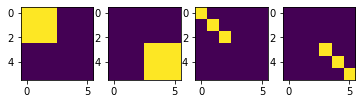

In [201]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1,H,i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

The first two components plotted above reflect the condition effect and model the covariance between items within each condition (observation, execution). The second two components reflect the item effect and model the item-specific variance for each item (3 hand gestures) in each condition.

To Simulate a dataset, we need to simulate an experimental design. Let's assume we measure the 6 trial types (3 items x 2 conditions) in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a dataset where there is a strong overall effect for both observation (exp(0)) and execution (exp(1)). In comparison, the item-specific effects for observation (exp(-1.5)) and execution ((exp(-1))) are pretty weak (this is a rather typical finding).

Note that all hyper parameters are log(variances)—this helps us to keep variances positive and the math easy. 

In [202]:
# Create the design. In this case it's 8 runs, 6 trial types!
cond_vec, part_vec = pcm.sim.make_design(n_cond=6, n_part=8)
#print(cond_vec)
#print(part_vec)

# Starting from the true model above, generate 20 datasets/participants with relatively low signal-to-noise ratio (2:10)
D = pcm.sim.make_dataset(model=Mtrue, theta=[1,2.7,0.4,0.2], cond_vec=cond_vec, part_vec=part_vec, n_sim=20, signal=0.2)

As a quick check, let's plot the predicted second moment matrix of our true model (using the simulation parameters) and the crossvalidated estimate from the first dataset. 

Text(0.5, 1.0, 'dataset')

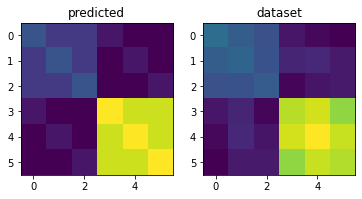

In [203]:
# Get the predicted G-matrix  from the true model
G,_ = Mtrue.predict([1,2.7,0.4,0.2])

# The estimated G-matrix from the first dataset 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements, trial_type, part_vec)

# Visualize the second moment (G) matrices
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')

plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('dataset')

### 2.2 Fitting the data 
Now we are fitting these datasets with a range of models, each assuming a correlation value between 0 and 1. The other parameters will still be included, as we did for the true model.

For comparison, we also include a flexible correlation model, which has a additional free parameter that models the correlation.

In [204]:
nsteps = 100 # how many correlation models?  
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1 
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=3, corr=r, cond_effect=True))
    
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=3, corr=None, cond_effect=True)
M.append(Mflex)

We can now fit the model to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model / dataset. The second return argument `theta` contains the parameters for each model fit. 

In [205]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=False, verbose=False)

T.head()

variable  likelihood                                                  \
model           0.00        0.01        0.02        0.03        0.04   
0        -940.371731 -940.265937 -940.162742 -940.062127 -939.964076   
1        -923.657494 -923.479462 -923.303472 -923.129493 -922.957498   
2        -970.093117 -969.846143 -969.602063 -969.360834 -969.122414   
3        -957.114391 -956.969350 -956.826571 -956.686029 -956.547701   
4        -923.600572 -923.425121 -923.252303 -923.082084 -922.914436   

variable                                                              ...  \
model           0.05        0.06        0.07        0.08        0.09  ...   
0        -939.868575 -939.775610 -939.685170 -939.597244 -939.511826  ...   
1        -922.787460 -922.619353 -922.453153 -922.288835 -922.126377  ...   
2        -968.886767 -968.653854 -968.423641 -968.196094 -967.971183  ...   
3        -956.411562 -956.277593 -956.145773 -956.016083 -955.888506  ...   
4        -922.749331 -922.586742 -922.426644 -922.269014 -922.113832  ...   

variable iterations                                               
model          0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00 flex  
0               6.0  6.0  6.0  7.0  7.0  7.0  7.0  7.0  7.0  6.0  
1               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  6.0  
2               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
3               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  5.0  
4               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  

[5 rows x 303 columns]

### 2.3 Interpreting the Fit 
Note that the absolute values of the log-likelihoods don't mean much. Therefore, first, we remove the mean log-likelihood for each correlation model, expressing each log-likelihood as the difference against the mean. Next, we plot the full log-likelihood curves (solid lines) and the maximum likelihood estimate (filled circles) of the correlation for each participant. We can also add the mean log-likelihood curve (dotted line) and the mean of the maximum log-likelihood estimates (vertical blue line) across participants.

Text(0, 0.5, 'log-likelihood')

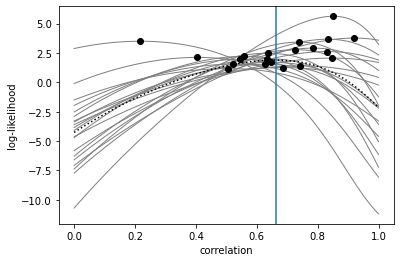

In [206]:
L = T.likelihood.to_numpy()

# express log-likelihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # Remove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i]= M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot 
plt.plot(r,L.T,color='gray', marker=None, linewidth=1)
plt.plot(maxr,maxL,'k.',markersize=12)
plt.plot(r,L.mean(axis=0),'k:')
plt.axvline(maxr.mean())
plt.xlabel('correlation')
plt.ylabel('log-likelihood')

As we can see, the maximum log-likelihood estimates behave quite well, but the mean of the maximum log-likelihood estimates (vertical line) is not exactly where the maximum of the mean (or group) log-likelihood lies (peak of the mean log-likelihood curve). 

One way to use the log-likelihoods is to do a paired-samples t-test between the log-likelihoods for two correlation values. For example, 0.7 vs 0.3:

In [207]:
print(f"Testing correlation of {r[69]:0.2f} against {r[30]:0.2f}")
t, p = ss.ttest_rel(L[:,69],L[:,30])
print(f'nPaired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

Testing correlation of 0.70 against 0.30
nPaired-samples t-test: t(19)=3.585; p(19)=0.001973


Alternatively, we can transform the log-likelihoods in approximate posterior distributions, and proceed with a Full Bayesian group analysis. 
For more accurate results, you probably want to space your correlation models more tightly.

Text(0, 0.5, 'posterior probability')

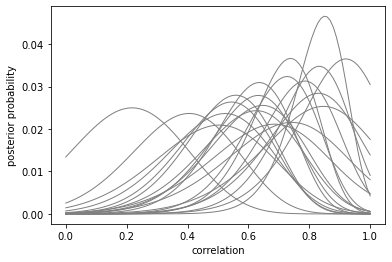

In [208]:
P = exp(L) # Take the exponential of the log-likelihoods
P = P / P.sum(axis=1).reshape(-1,1) # Normalize to 1 over domain 
plt.plot(r,P.T,color='gray', marker=None, linewidth=1)
plt.xlabel('correlation')
plt.ylabel('posterior probability')